In [2]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt


## Основные функции

In [ ]:
def process_log(file, temperature):
    '''
    Обрабатывает данные из log файлов
    
    Args:
        file (str): название файла
        temperature (float): значение температуры для рассчета теплоёмкости
        
    '''
    

    df = pd.read_csv(file, sep='\t')

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(df['Step'], df['Energy'])
    axs[1].plot(df['Step'], df['MagMom'])
    axs[0].set_title('Energy')
    axs[1].set_title('Magnetization')
    axs[0].set_xlabel('Step')
    axs[1].set_xlabel('Step')

    energy = df['Energy'][100:]
    print(f'Mean energy: {energy.mean():.3f}', f'Std energy: {energy.std():.3f}', sep='\n')
    print(f'Mean magnetization: {df["MagMom"].mean():.3f}', f'Std magnetization: {df["MagMom"].std():.3f}', sep='\n')

    capacity = energy.std() ** 2 / temperature ** 2
    print(f'Specific heat capacity: {capacity:.5f}')

In [ ]:

def ising(temperature, grid_size, ncycles, dump_rate, print_output=True, process_data=True):
    
    """Запускает процесс расчёта модели изинга
    
    Args:
        temperature (float)
        grid_size (int)
        dump_rate (int): частота записи файлов
        print_output (bool): флаг для печати свойств системы (энергии, магнитного момента) с частотой dump_rate
        process_data (bool): флаг для вывода энергии и магнитного момента системы от времени в течение всей симуляции
    
    """
    
    
    def MKstep(E, M):
    
        x = np.random.randint(0, grid_size)
        y = np.random.randint(0, grid_size)
    
        curr_spin = grid[x, y]
        
        top = grid[x, (y - 1) % grid_size]
        left = grid[(x - 1) % grid_size, y]
        bottom = grid[x, (y + 1) % grid_size]
        right = grid[(x + 1) % grid_size, y]
        delta_E = 2 * curr_spin * (top + left + bottom + right)    
        
        xi = np.random.random()
    
        if (xi < np.exp(- delta_E / temperature)):
            
            grid[x, y] *= -1
            return E + delta_E, M + 2 * grid[x, y] / grid_size ** 2
        
        return E, M
    
    def save_xyz(file, grid, step):
        N = grid_size ** 2
        file.write(f"{N}\n")
        file.write(f"Step: {step}\n")
        for x in range(grid_size):
            for y in range(grid_size):
                spin = grid[x, y]
                file.write(f"Fe {x} {y} {spin}\n")
        
    
    # grid = np.random.randint(0, 2, (grid_size, grid_size)) * 2 - 1
    grid = np.ones((grid_size, grid_size))
    
    E = 0
    M = 0
    for x in range(grid_size):
        for y in range(grid_size):
            curr_spin = grid[x, y]
            
            top = grid[x, (y - 1) % grid_size]
            left = grid[(x - 1) % grid_size, y]
            bottom = grid[x, (y + 1) % grid_size]
            right = grid[(x + 1) % grid_size, y]
            
            
            E_i = - 0.5 * curr_spin * (top + left + bottom + right)
            M += curr_spin
            E += E_i
    
    M /= grid_size ** 2
    # return E, M

    output_file = f'./dumps_{grid_size}/ising_{temperature}.xyz'
    log_file = f'./logs_{grid_size}/ising_{temperature}.log'
    with open(output_file, 'w') as file:
        with open(log_file, 'w') as log:
            log.write('Step\tEnergy\tMagMom\n')
            if print_output: print('Step', 'Energy', 'MagMom', sep='\t')
            for i in range(ncycles+1):
                E, M = MKstep(E, M)
                if i % dump_rate == 0: 
                    save_xyz(file, grid, i)
                    
                    if print_output: print(i, f'{E / grid_size ** 2:4.5f}', f'{M:.5f}', sep='\t')
                    log.write(f'{i}\t{E / grid_size ** 2:4.5f}\t{M:1.5f}\n')
                
    if process_data:process_log(log_file, temperature)


## Сетка 20x20

Mean energy: -1.997
Std energy: 0.008
Mean magnetization: 0.999
Std magnetization: 0.002
Specific heat capacity: 0.00004


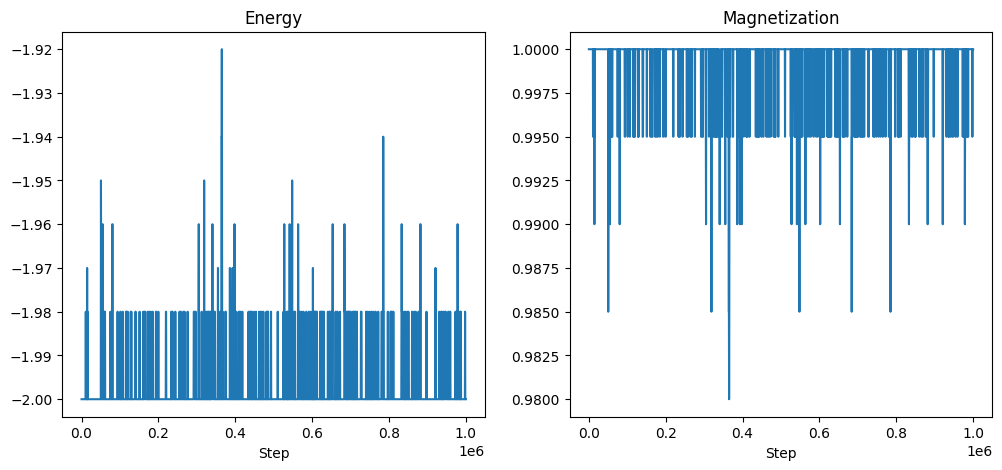

In [197]:
ising(temperature=1, grid_size=20, ncycles=1000000, dump_rate=500, print_output=False, process_data=True)

In [ ]:



from concurrent.futures import ThreadPoolExecutor

temperatures = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.3, 2.35, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6]
grid_size = 20
ncycles = 1000000
dump_rate = 500

def run_ising(temp):
    ising(temperature=temp, grid_size=grid_size, ncycles=ncycles, dump_rate=dump_rate, print_output=False, process_data=False)

with ThreadPoolExecutor() as executor:
    executor.map(run_ising, temperatures)        
    

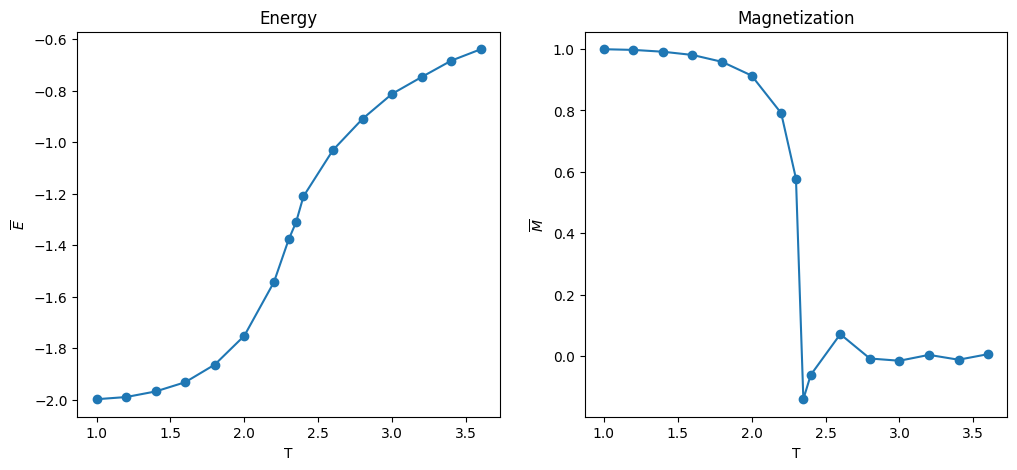

In [21]:
logs = sorted(os.listdir('./logs_20'), key=lambda x: float(x.split('_')[1].split('.log')[0]))
T = [float(log.split('_')[1].replace('.log', '')) for log in logs]
E = []
E_vars = []
M = []

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for file in logs:
    df = pd.read_csv('./logs_20/' + file, sep='\t')
    energy = df['Energy'][100:]
    E.append(energy.mean())
    E_vars.append(energy.var())
    M.append(df['MagMom'][100:].mean())

axs[0].plot(T, E, marker='o')
axs[0].set_xlabel('T')
axs[0].set_ylabel('$\overline{E}$')
axs[0].set_title('Energy')
axs[1].plot(T, M, marker='o')
axs[1].set_xlabel('T')
axs[1].set_ylabel('$\overline{M}$')
axs[1].set_title('Magnetization');


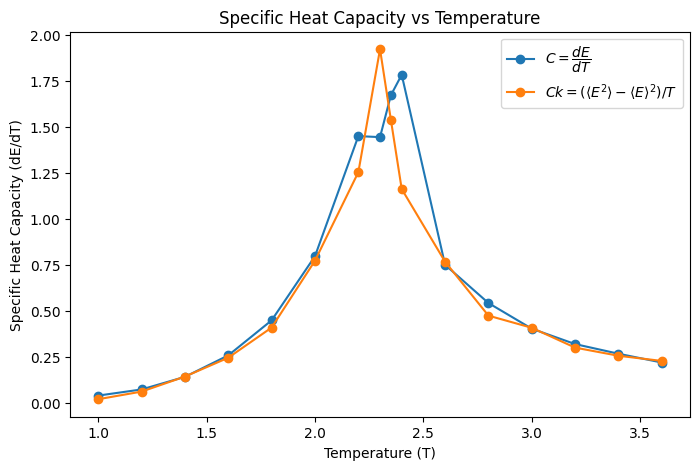

In [ ]:
dE_dT = np.gradient(E, T)

plt.figure(figsize=(8, 5))
plt.plot(T, dE_dT, marker='o', label='$C = \dfrac{dE}{dT}$')
plt.xlabel('Temperature (T)')
plt.ylabel('Specific Heat Capacity (dE/dT)')
plt.title('Specific Heat Capacity vs Temperature')
# plt.grid(True)


heat_capacity = np.array(E_vars) / np.array(T) ** 2

plt.plot(T, heat_capacity * 400, marker='o', label=r'$C k= (\langle E^2\rangle - \langle E \rangle ^ 2) / T$')

plt.legend()
plt.show()

## Сетка 100x100

Mean energy: -1.025
Std energy: 0.022
Mean magnetization: 0.086
Std magnetization: 0.168
Specific heat capacity: 0.00019
CPU times: user 1min 6s, sys: 331 ms, total: 1min 6s
Wall time: 1min 6s


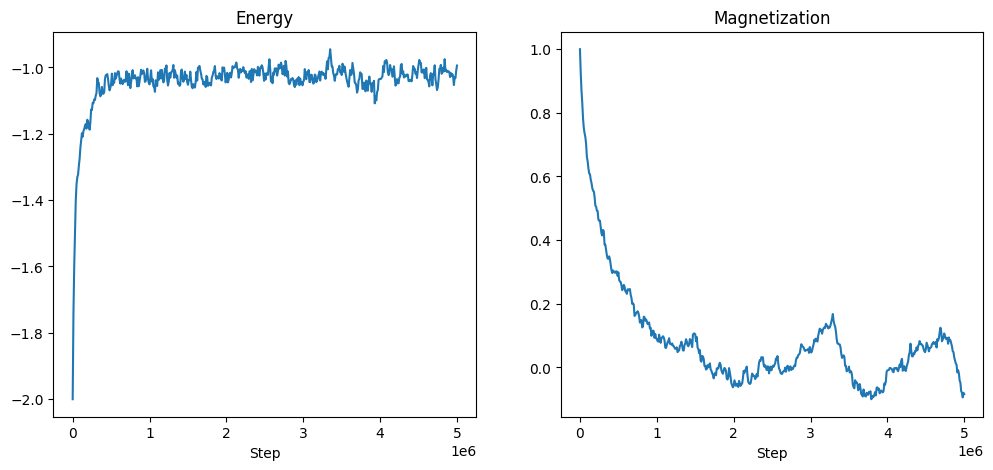

In [21]:
%%time
ising(temperature=2.6, grid_size=100, ncycles=5000000, dump_rate=10000, print_output=False, process_data=True)

In [254]:
from concurrent.futures import ThreadPoolExecutor

temperatures = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.3, 2.35, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6]
grid_size = 100
ncycles = 5000000
dump_rate = 10000

def run_ising(temp):
    ising(temperature=temp, grid_size=grid_size, ncycles=ncycles, dump_rate=dump_rate, print_output=False, process_data=False)

with ThreadPoolExecutor() as executor:
    executor.map(run_ising, temperatures)

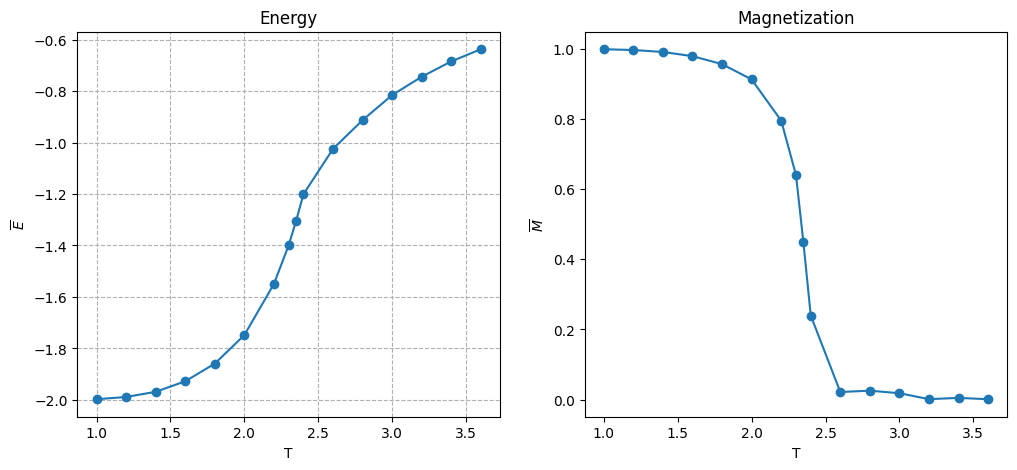

In [34]:
logs = sorted(os.listdir('./logs_100'), key=lambda x: float(x.split('_')[1].split('.log')[0]))
T = [float(log.split('_')[1].split('.log')[0]) for log in logs]
E = []
E_vars = []
M = []
M_vars = []

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for file in logs:
    df = pd.read_csv('./logs_100/' + file, sep='\t')
    energy = df['Energy'][100:]
    E.append(energy.mean())
    E_vars.append(energy.var())
    M.append(df['MagMom'][100:].mean())
    M_vars.append(df['MagMom'].var())

    
axs[0].plot(T, E, marker='o')
axs[0].set_xlabel('T')
axs[0].set_ylabel('$\overline{E}$')
axs[0].set_title('Energy')
axs[0].grid(True, linestyle='--')
axs[1].plot(T, M, marker='o')
axs[1].set_xlabel('T')
axs[1].set_ylabel('$\overline{M}$')
axs[1].set_title('Magnetization');


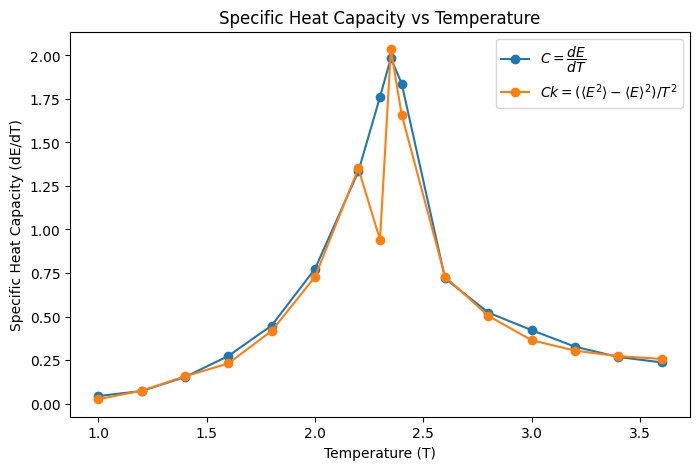

In [35]:
dE_dT = np.gradient(E, T)

plt.figure(figsize=(8, 5))
plt.plot(T, dE_dT, marker='o', label='$C = \dfrac{dE}{dT}$')
plt.xlabel('Temperature (T)')
plt.ylabel('Specific Heat Capacity (dE/dT)')
plt.title('Specific Heat Capacity vs Temperature')
# plt.grid(True)


heat_capacity = np.array(E_vars) / np.array(T) ** 2
plt.plot(T, heat_capacity * 1e4, marker='o', label=r'$Ck = (\langle E^2\rangle - \langle E \rangle ^ 2) / T ^ 2$')

plt.legend()
plt.show()

In [24]:
T[np.argmax(heat_capacity)]

2.35

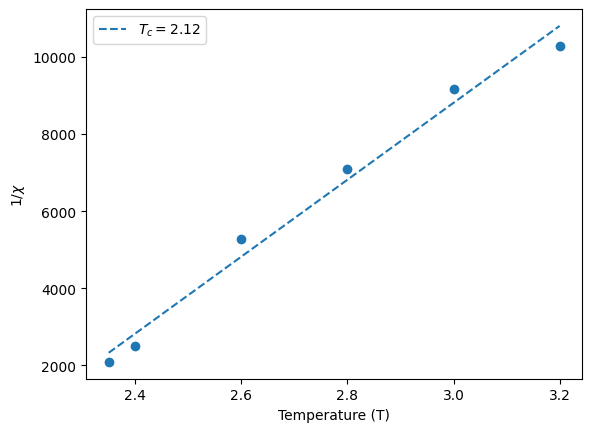

In [32]:
from scipy.stats import linregress
st = 8

chi = (np.array(E_vars) / np.array(T))[st:-2]
T_positive = np.array(T[st:-2])
plt.scatter(T_positive, 1 / chi)
plt.xlabel('Temperature (T)')
plt.ylabel('$1 / \chi$')

res = linregress(T_positive, 1 / chi)
plt.plot(T_positive, T_positive * res.slope + res.intercept, linestyle='--', label=f'$T_c = {- res.intercept / res.slope:.2f}$')
plt.legend();
# plt.plot(T_positive, 1 / (T_positive - 2.2) / 1e4);